# Aplicación de Multilayer Perceptron en clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw -10

- **Nombre:** Diego Valdés
- **Profesora:** Violeta Chang Camacho



## Objetivo de la tarea

El objetivo de esta tarea es entender y aplicar redes neuronales para clasificar imágenes. Así, en esta tarea el foco estará en la clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim 
from tqdm import trange



## Extracción de los datos de QuickDraw-10 y QuickDraw-Animals
Se verifica que la carpeta contiene las siguientes carpetas y archivos:

* mapping.txt: Mapea las etiquetas a las clases.

* train.txt: Contiene las rutas a las imágenes de entrenamiento y sus respectivas etiquetas.

* test.txt: Contiene las rutas a las imágenes de prueba y sus respectivas etiquetas.

* images/: Carpeta con las imágenes de todos los dibujos.

In [2]:
# Ruta del archivo descomprimido
ruta_base = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"

print("Archivos dentro de QuickDraw-10:")
archivos = os.listdir(ruta_base)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)


Archivos dentro de QuickDraw-10:
images
mapping.txt
test.txt
train.txt


In [3]:
# Ruta del archivo descomprimido
ruta_base = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

print("Archivos dentro de QuickDraw-Animals:")
archivos = os.listdir(ruta_base)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)

Archivos dentro de QuickDraw-Animals:
mapping.txt
test_images
train_images


# Carga y estructura de los datos de Quickdraw-10


Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_train10.shape = (9834, 256, 256): contiene 9834 imágenes de entrenamiento.

* y_train10.shape = (9834,): etiquetas correspondientes a X_train, con valores entre 0 y 9 (una por clase).

* X_test10.shape = (1166, 256, 256): contiene 1166 imágenes de prueba.

* y_test10.shape = (1166,): etiquetas correspondientes a X_test.

In [4]:
# Para QuickDraw-10

etiquetas_quickdraw10 = {
    0: "sink",1: "castle",2: "lion",
    3: "teapot",4: "flashlight",5: "blackberry",
    6: "spreadsheet",7: "bandage", 8: "remote-control",9: "trombone"
}

In [5]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA

IMG_SIZE = 256

def cargartxt(txt_path, base_dir):
    X = []
    y = []
    with open(txt_path, 'r') as f:
        lineas = f.readlines()
        for linea in tqdm(lineas, desc=f"Cargando {os.path.basename(txt_path)}"):
            ruta_rel, etiqueta = linea.strip().split()
            ruta_img = os.path.join(base_dir, ruta_rel)
            try:
                img = Image.open(ruta_img).convert("L").resize((IMG_SIZE, IMG_SIZE))
                img_np = np.array(img, dtype=np.float32) / 255.0  
                img_flat = img_np.flatten()  
                X.append(img_flat)
                y.append(int(etiqueta))
            except Exception as e:
                print(f"Error al leer {ruta_img}: {e}")
    return np.array(X), np.array(y)

BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"
X_train10, y_train10 = cargartxt(os.path.join(BASE_DIR, "train.txt"), BASE_DIR)
X_test10, y_test10 = cargartxt(os.path.join(BASE_DIR, "test.txt"), BASE_DIR)

print("Antes de PCA:")
print("X_train:", X_train10.shape, "y_train:", y_train10.shape)
print("X_test:", X_test10.shape, "y_test:", y_test10.shape)

# PCA reducción a 256 componentes
pca = PCA(n_components=256)
X_train10_pca = pca.fit_transform(X_train10)
X_test10_pca = pca.transform(X_test10)

print("Después de PCA:")
print("X_train_pca:", X_train10_pca.shape)
print("X_test_pca:", X_test10_pca.shape)


Cargando test.txt: 100%|██████████| 1166/1166 [00:15<00:00, 77.58it/s]


Antes de PCA:
X_train: (9834, 65536) y_train: (9834,)
X_test: (1166, 65536) y_test: (1166,)
Después de PCA:
X_train_pca: (9834, 256)
X_test_pca: (1166, 256)


# Carga y estructura de los datos de Quickdraw-Animals

Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_trainA.shape = (12000, 256, 256): contiene 12000 imágenes de entrenamiento.

* y_trainA.shape = (12000,): etiquetas correspondientes a X_train, con valores entre 0 y 11 (una por clase).

* X_testA.shape = (2399, 256, 256): contiene 2399 imágenes de prueba.

* y_testA.shape = (2399,): etiquetas correspondientes a X_test.

In [6]:
etiquetas_animals = {
        "sheep": 0, "bear": 1, "bee": 2, "cat": 3, "camel": 4,
        "cow": 5, "crab": 6, "crocodile": 7, "duck": 8, "elephant": 9,
        "dog": 10, "giraffe": 11
    }

In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA



def cargar_dataset_animals(path_dir):
    X = []
    y = []
    
    for clase in os.listdir(path_dir):
        carpeta_clase = os.path.join(path_dir, clase)
        if not os.path.isdir(carpeta_clase):
            continue
        label = etiquetas_animals.get(clase)
        if label is None:
            continue
        for archivo in os.listdir(carpeta_clase):
            archivo_path = os.path.join(carpeta_clase, archivo)
            try:
                img = Image.open(archivo_path).convert("L")  
                img = img.resize((256, 256))  
                img_np = np.array(img).flatten() 
                X.append(img_np)
                y.append(label)
            except:
                pass  

    X = np.array(X, dtype=np.float32) / 255.0  
    y = np.array(y, dtype=np.int64)
    return X, y


BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

X_trainA, y_trainA = cargar_dataset_animals(os.path.join(BASE_DIR, "train_images"))
X_testA, y_testA = cargar_dataset_animals(os.path.join(BASE_DIR, "test_images"))

print("X_train:", X_trainA.shape, "y_train:", y_trainA.shape)
print("X_test:", X_testA.shape, "y_test:", y_testA.shape)

# Crear PCA con 256 componentes
pca = PCA(n_components=256)

# Ajustar PCA solo con entrenamiento y transformar ambos sets
X_trainA_pca = pca.fit_transform(X_trainA)
X_testA_pca = pca.transform(X_testA)

print("Después de PCA:")
print("X_trainA_pca:", X_trainA_pca.shape)
print("X_testA_pca:", X_testA_pca.shape)

X_train: (12000, 65536) y_train: (12000,)
X_test: (2399, 65536) y_test: (2399,)
Después de PCA:
X_trainA_pca: (12000, 256)
X_testA_pca: (2399, 256)


# Visualización de las imágenes



Para corroborar que las imágenes estan cargando correctamente se escogeran algunas y se mostrarán.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def mostrar_imagenes_random(X, y, cantidad=50, etiquetas_dict=None, titulo="Muestras Aleatorias"):
   
    idx = np.random.choice(len(X), size=cantidad, replace=False)
    imagenes = [X[i].reshape(256, 256) for i in idx]
    etiquetas = [y[i] for i in idx]

    filas = cantidad // 10
    fig, axes = plt.subplots(filas, 10, figsize=(20, 2.5 * filas))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imagenes[i], cmap='gray')
        ax.axis('off')
        label = etiquetas[i]
        label_str = etiquetas_dict[label] if etiquetas_dict else str(label)
        ax.set_title(f'Label: {label_str}')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()


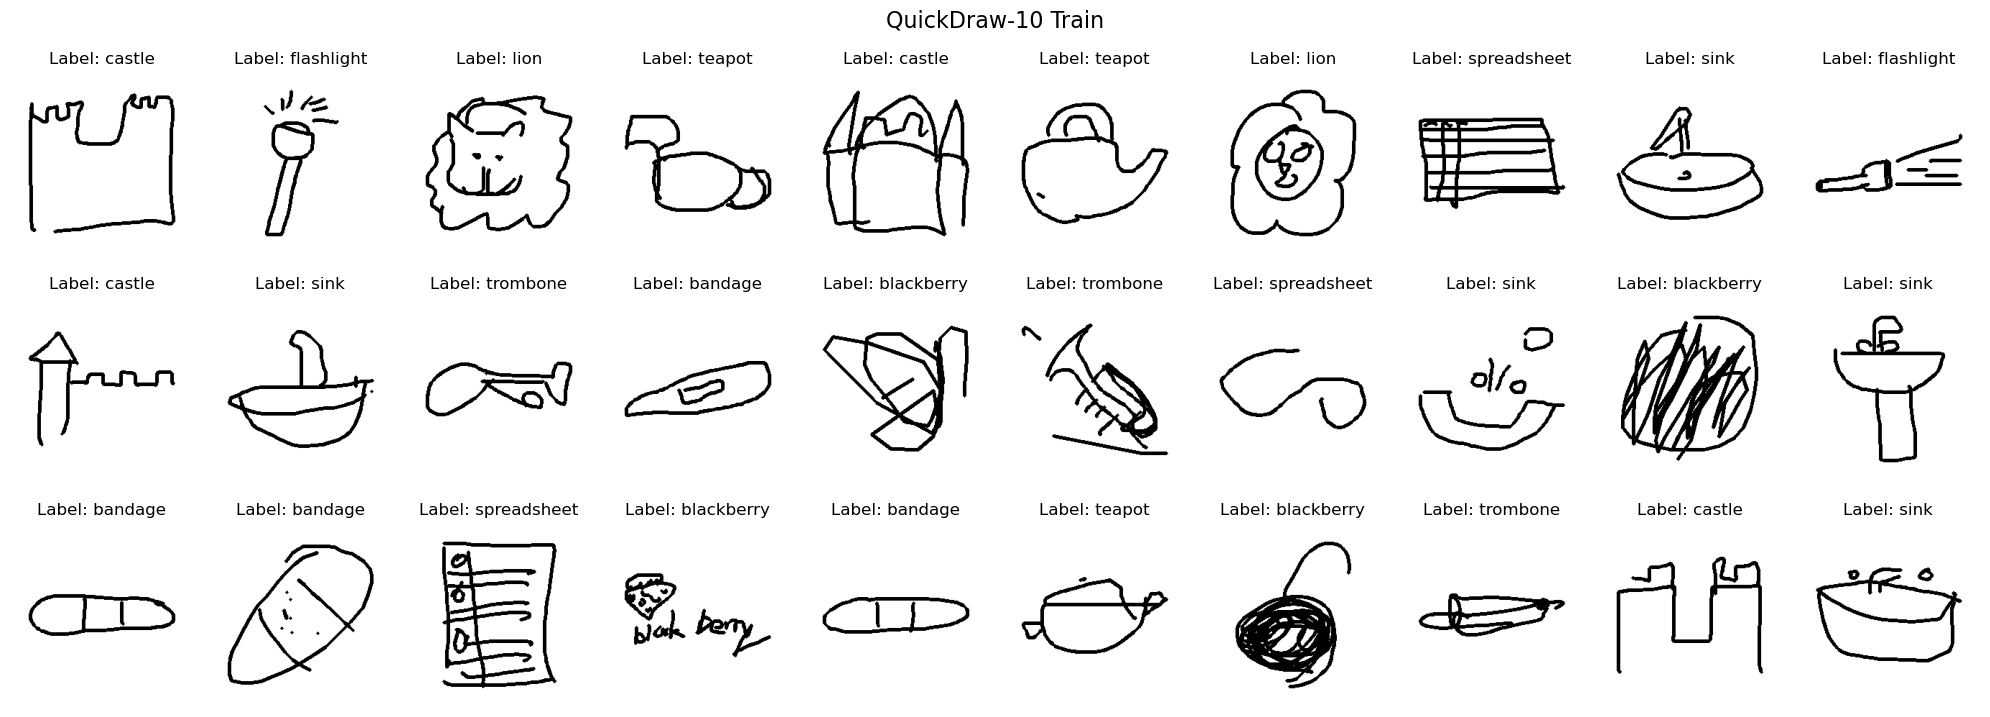

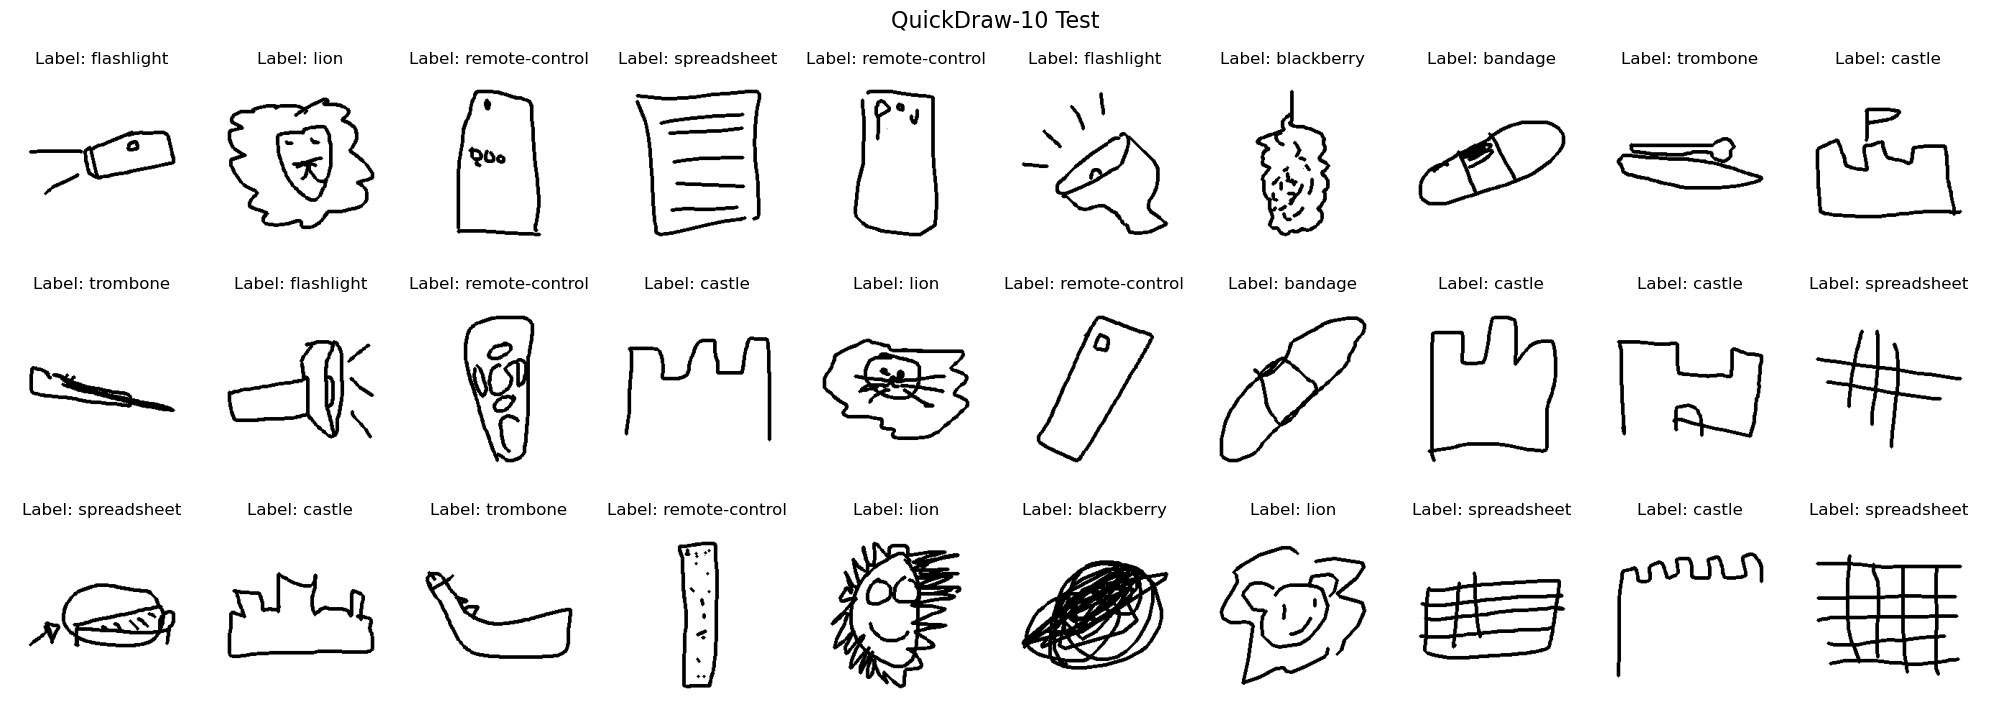

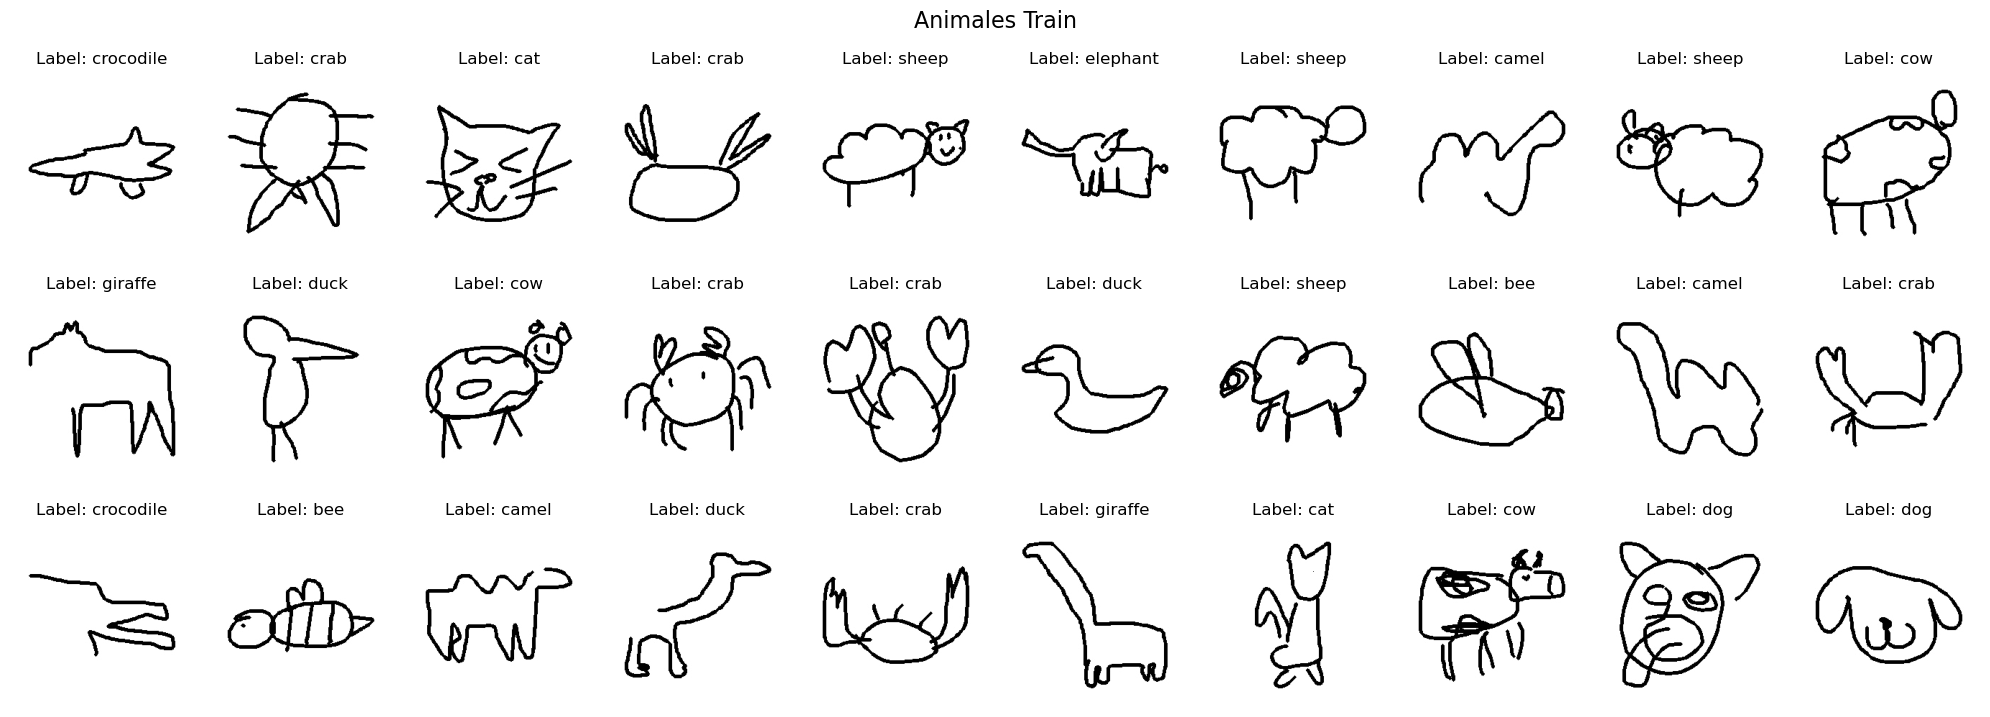

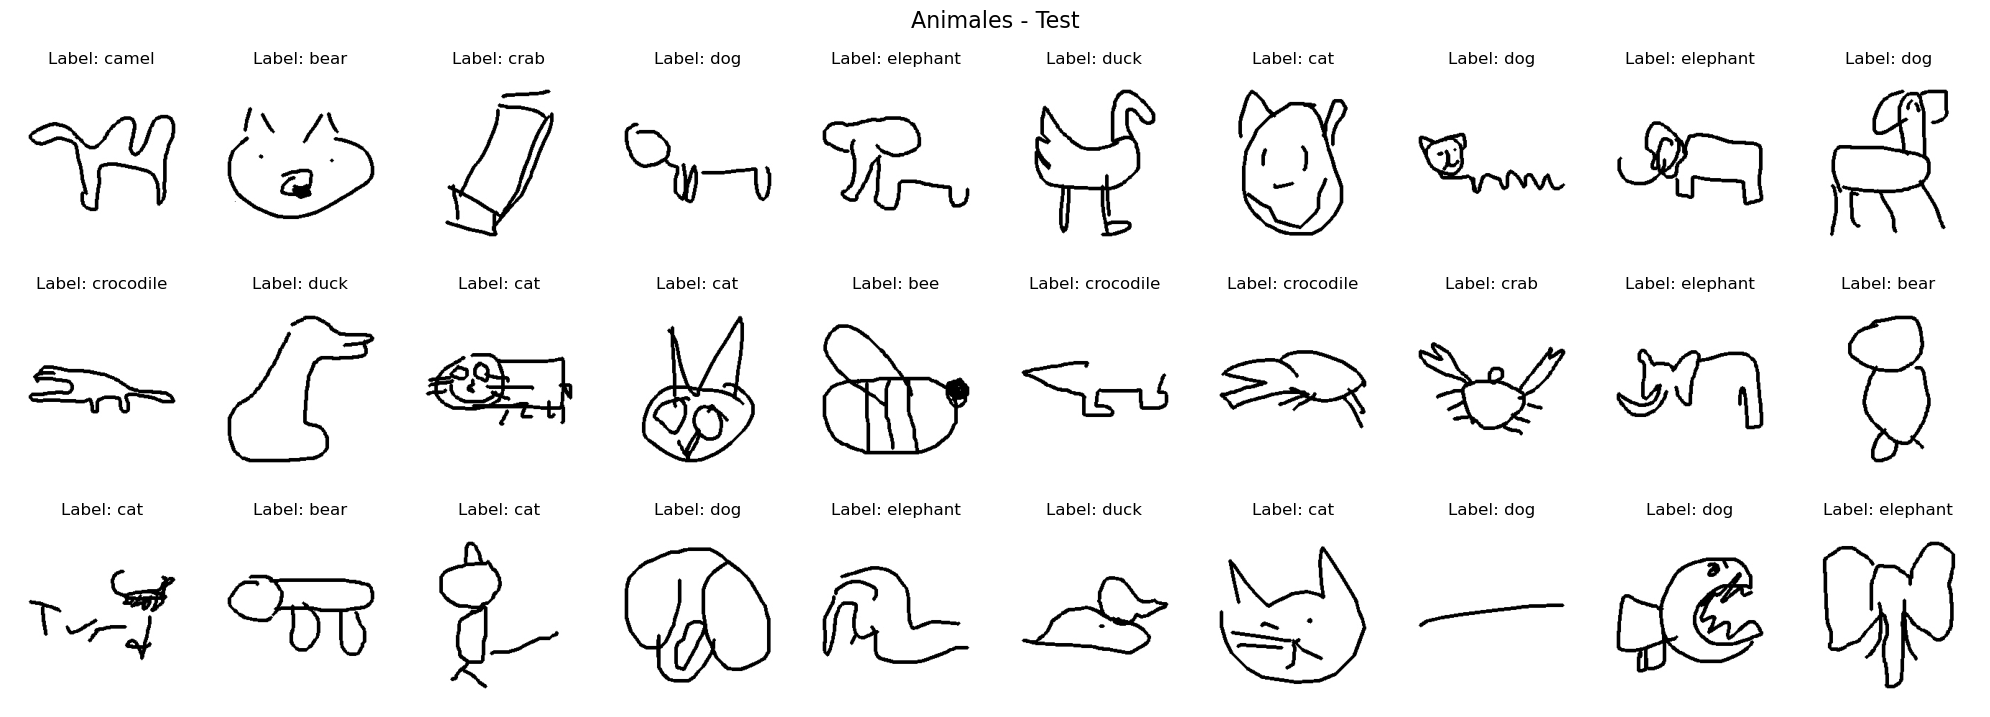

In [23]:
# Para QuickDraw-10
mostrar_imagenes_random(X_train10, y_train10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Train")
mostrar_imagenes_random(X_test10, y_test10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Test")

#  QuickDraw-Animals 
mostrar_imagenes_random(X_trainA, y_trainA, cantidad=30, etiquetas_dict=etiquetas_animals, titulo="Animales Train")
mostrar_imagenes_random(X_testA, y_testA, cantidad=30, etiquetas_dict=etiquetas_animals, titulo="Animales - Test")



In [9]:
modelos = [
    {
        "hidden_layers": [256, 128],
        "activation_fns": [nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP1 - 2 capas ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [512, 256, 128],
        "activation_fns": [nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP2 - 3 capas Tanh/ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [256, 128, 64, 32],
        "activation_fns": [nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.NLLLoss,
        "nombre": "MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss"
    }
]


In [10]:
class MLP_general(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fns, output_size, use_logsoftmax=False):
        super().__init__()
        layers = []
        in_features = input_size
        for h, act_fn in zip(hidden_layers, activation_fns):
            layers.append(nn.Linear(in_features, h))
            layers.append(act_fn())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        if use_logsoftmax:
            layers.append(nn.LogSoftmax(dim=1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [18]:
def evaluar_varias_veces_general(X_train_np, y_train_np, X_test_np, y_test_np,
                                hidden_layers, activation_fns, loss_fn_class,
                                repeticiones=5, epochs=20, lr=0.001, batch_size=32, etiquetas=None,
                                use_logsoftmax=False):

    accuracies = []
    accuracies_por_clase = []
    matrices_conf = []

    input_size = X_train_np.shape[1]
    output_size = len(np.unique(y_train_np))

    X_train_all = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_all = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    for i in range(repeticiones):
        model = MLP_general(input_size, hidden_layers, activation_fns, output_size, use_logsoftmax)
        criterion = loss_fn_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = torch.utils.data.TensorDataset(X_train_all, y_train_all)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            loop = trange(len(loader), desc=f"Iteración {i+1} Epoch {epoch+1}", leave=False)
            for j, (inputs, labels) in zip(loop, loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                acc = correct / total
                loop.set_postfix(accuracy=acc, loss=running_loss / (j + 1))

        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            preds = outputs.argmax(dim=1)
            acc_total = accuracy_score(y_test, preds)
            loss = criterion(outputs, y_test).item()
            matriz = confusion_matrix(y_test, preds)

        with np.errstate(divide='ignore', invalid='ignore'):
            clase_sum = matriz.sum(axis=0)
            clase_sum[clase_sum == 0] = 1
            acc_clase = matriz.diagonal() / clase_sum

        accuracies.append(acc_total)
        accuracies_por_clase.append(acc_clase)
        matrices_conf.append(matriz)

        print(f"\nIteración {i} - Accuracy Total: {acc_total:.4f} - Loss: {loss:.4f}")
        print(f"Accuracy por cada clase en Iteración {i} : {acc_clase}")
        print("-" * 80)

    acc_median = np.median(accuracies)
    acc_clase_median = np.nanmedian(np.array(accuracies_por_clase), axis=0)
    median_cm = np.nanmedian(np.array(matrices_conf), axis=0).astype(int)

    disp = ConfusionMatrixDisplay(confusion_matrix=median_cm, display_labels=etiquetas)
    disp.plot(xticks_rotation=45)
    plt.title("Matriz de Confusión Mediana")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    if etiquetas is None:
        clases = np.arange(len(acc_clase_median))
    elif isinstance(etiquetas, dict):
        clases = [etiquetas[k] for k in sorted(etiquetas.keys())]
    else:
        clases = etiquetas

    plt.bar(clases, acc_clase_median)
    plt.title("Accuracy por clase (mediana)")
    plt.xlabel("Clases")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()
    return accuracies, acc_median, acc_clase_median


## MLP 1,2 y 3 con Quickdraw-10


Entrenando MLP1 - 2 capas ReLU + CrossEntropy...


Iteración 1 Epoch 1:   0%|          | 0/308 [00:00<?, ?it/s]


Iteración 0 - Accuracy Total: 0.7230 - Loss: 2.0418
Accuracy por cada clase en Iteración 0 : [0.63013699 0.72881356 0.72881356 0.83809524 0.73214286 0.66666667
 0.7826087  0.75       0.8046875  0.56122449]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.6955 - Loss: 2.3582
Accuracy por cada clase en Iteración 1 : [0.67460317 0.59064327 0.75423729 0.80188679 0.59230769 0.74698795
 0.76190476 0.75609756 0.8019802  0.5631068 ]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7058 - Loss: 2.0590
Accuracy por cada clase en Iteración 2 : [0.69047619 0.80851064 0.6618705  0.72093023 0.68316832 0.73563218
 0.7265625  0.71755725 0.76377953 0.55769231]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7273 - Loss: 2.1389
Accuracy por cada clase en Iteración 3 : [0.65714286 0.7398374  0.69827586 0.8125     0.68468468 0.76404494
 0.74576271 0.82142857 0.82786885 0.55284553]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7273 - Loss: 2.0801
Accuracy por cada clase en Iteración 4 : [0.73770492 0.77981651 0.80769231 0.88888889 0.7029703  0.65765766
 0.68531469 0.8        0.74324324 0.5       ]
--------------------------------------------------------------------------------


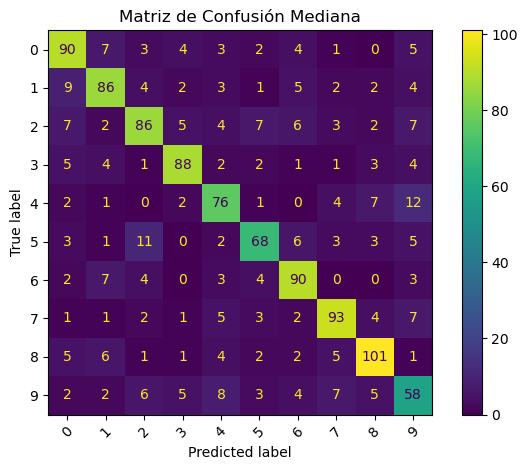

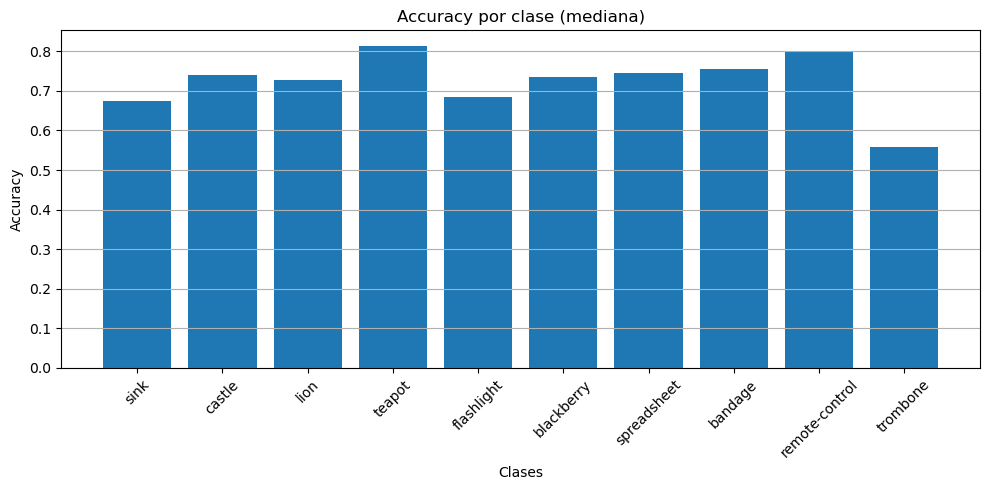

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy: 0.7230

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy...



Iteración 0 - Accuracy Total: 0.7204 - Loss: 2.1769
Accuracy por cada clase en Iteración 0 : [0.64       0.73043478 0.72881356 0.83486239 0.63709677 0.7311828
 0.73275862 0.77419355 0.87619048 0.5625    ]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.6887 - Loss: 2.4675
Accuracy por cada clase en Iteración 1 : [0.56962025 0.76086957 0.69642857 0.83636364 0.57971014 0.67346939
 0.65079365 0.734375   0.81102362 0.62337662]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7196 - Loss: 2.1366
Accuracy por cada clase en Iteración 2 : [0.67647059 0.79245283 0.71794872 0.85840708 0.70103093 0.7
 0.703125   0.6969697  0.8030303  0.53333333]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7316 - Loss: 1.9833
Accuracy por cada clase en Iteración 3 : [0.75833333 0.69465649 0.75       0.77777778 0.66956522 0.70873786
 0.74774775 0.8627451  0.81300813 0.54621849]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7213 - Loss: 2.3604
Accuracy por cada clase en Iteración 4 : [0.73015873 0.75       0.80373832 0.78070175 0.65714286 0.68
 0.76271186 0.79245283 0.80314961 0.50340136]
--------------------------------------------------------------------------------


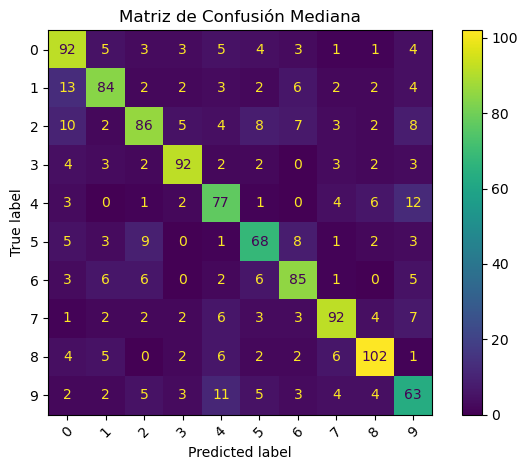

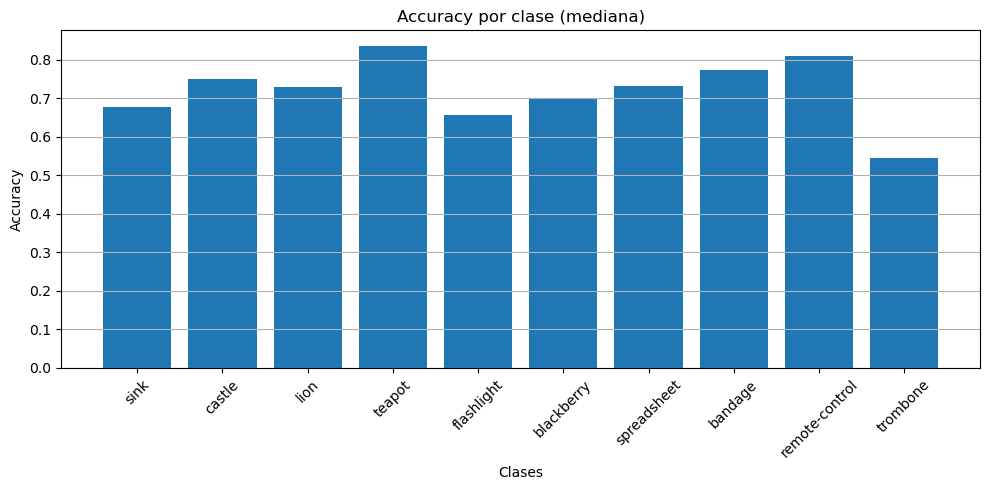

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy: 0.7204

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss...



Iteración 0 - Accuracy Total: 0.7093 - Loss: 1.9073
Accuracy por cada clase en Iteración 0 : [0.7008547  0.75438596 0.68992248 0.78761062 0.56428571 0.71134021
 0.7704918  0.671875   0.85321101 0.6185567 ]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7213 - Loss: 1.7720
Accuracy por cada clase en Iteración 1 : [0.66423358 0.77586207 0.76576577 0.89795918 0.7047619  0.71
 0.69172932 0.65714286 0.784      0.59405941]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7110 - Loss: 1.9133
Accuracy por cada clase en Iteración 2 : [0.61111111 0.74074074 0.70535714 0.86792453 0.65891473 0.65740741
 0.76237624 0.77310924 0.85470085 0.53278689]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7264 - Loss: 1.7863
Accuracy por cada clase en Iteración 3 : [0.671875   0.71875    0.74766355 0.81904762 0.66666667 0.61788618
 0.82568807 0.875      0.8046875  0.55263158]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.6938 - Loss: 1.9592
Accuracy por cada clase en Iteración 4 : [0.66129032 0.7979798  0.69117647 0.8        0.65957447 0.59259259
 0.76363636 0.83157895 0.80327869 0.44680851]
--------------------------------------------------------------------------------


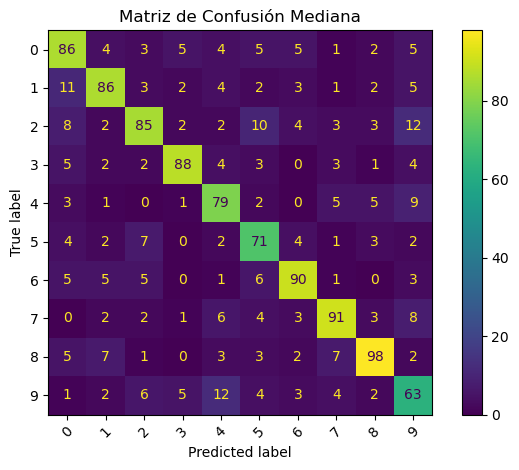

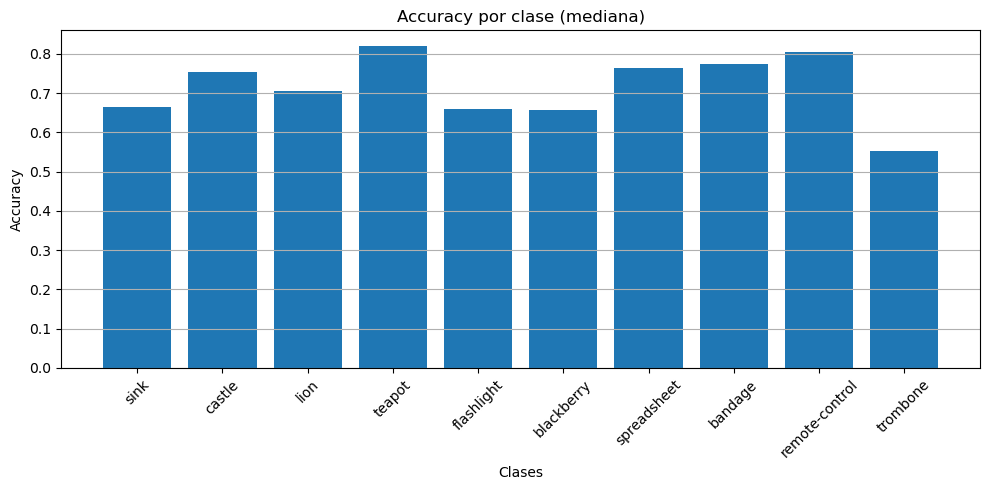

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss: 0.7110


In [22]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']}...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_train10_pca, y_train10, X_test10_pca, y_test10,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_quickdraw10,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']}: {mediana_acc:.4f}")


## MLP 1,2 y 3 con Quickdraw-Animals


Entrenando MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals...


Iteración 1 Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]


Iteración 0 - Accuracy Total: 0.5198 - Loss: 4.2487
Accuracy por cada clase en Iteración 0 : [0.57407407 0.47852761 0.59259259 0.39004149 0.62698413 0.3670412
 0.58433735 0.66350711 0.58857143 0.46703297 0.25321888 0.77391304]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5298 - Loss: 4.1435
Accuracy por cada clase en Iteración 1 : [0.53917051 0.47619048 0.58454106 0.47715736 0.51658768 0.36363636
 0.56632653 0.7027027  0.65644172 0.48823529 0.23391813 0.7375    ]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5244 - Loss: 4.1450
Accuracy por cada clase en Iteración 2 : [0.57837838 0.48351648 0.56666667 0.46842105 0.50431034 0.37391304
 0.49557522 0.69565217 0.57142857 0.50318471 0.27314815 0.82926829]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5319 - Loss: 4.2924
Accuracy por cada clase en Iteración 3 : [0.591133   0.44711538 0.55045872 0.53142857 0.58709677 0.37339056
 0.59459459 0.67298578 0.55882353 0.5060241  0.2518797  0.83490566]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5223 - Loss: 4.2817
Accuracy por cada clase en Iteración 4 : [0.63218391 0.58267717 0.63190184 0.53125    0.47368421 0.35907336
 0.50980392 0.71590909 0.57446809 0.44196429 0.22857143 0.76724138]
--------------------------------------------------------------------------------


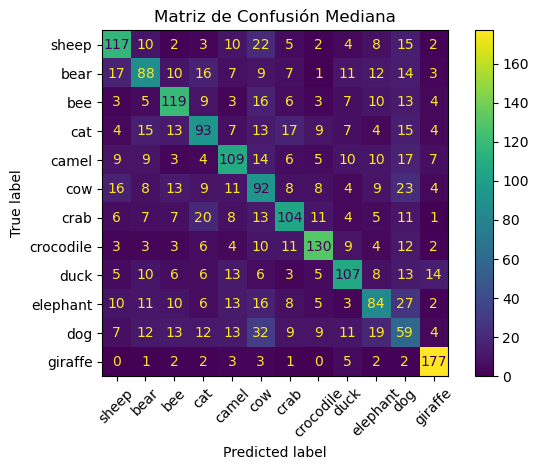

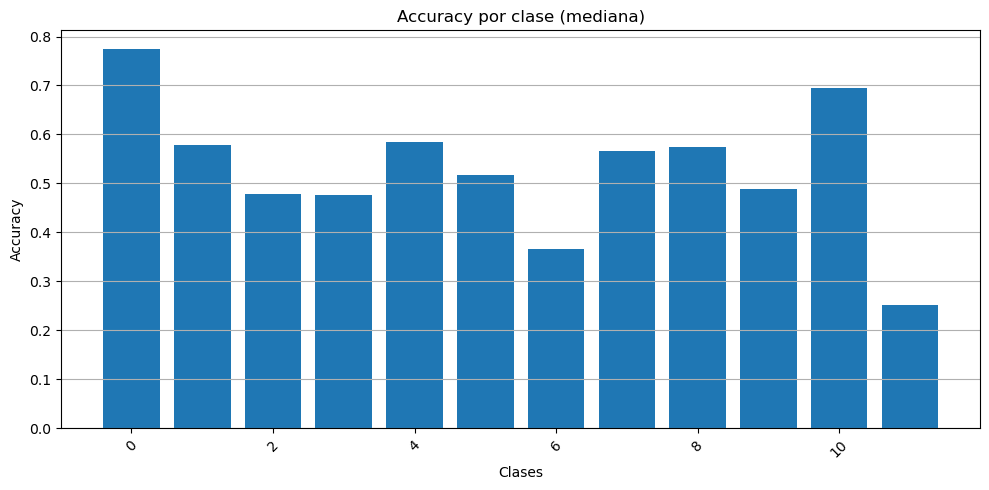

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals: 0.5244

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5185 - Loss: 4.5044
Accuracy por cada clase en Iteración 0 : [0.60795455 0.56462585 0.56410256 0.42982456 0.5480226  0.38219895
 0.5988024  0.56470588 0.56544503 0.46111111 0.24701195 0.74273859]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5065 - Loss: 4.2720
Accuracy por cada clase en Iteración 1 : [0.60301508 0.50588235 0.48717949 0.43956044 0.45714286 0.42196532
 0.45955882 0.72413793 0.54148472 0.40641711 0.2513369  0.80094787]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5327 - Loss: 4.1289
Accuracy por cada clase en Iteración 2 : [0.58849558 0.52222222 0.62637363 0.45685279 0.57055215 0.42777778
 0.54950495 0.68390805 0.58045977 0.45238095 0.27037037 0.73858921]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5198 - Loss: 4.1990
Accuracy por cada clase en Iteración 3 : [0.59459459 0.47058824 0.58744395 0.49717514 0.49528302 0.46511628
 0.54901961 0.57142857 0.57303371 0.44670051 0.22304833 0.835     ]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5227 - Loss: 4.2294
Accuracy por cada clase en Iteración 4 : [0.58744395 0.568      0.51209677 0.49509804 0.58169935 0.38235294
 0.6350365  0.68911917 0.5988024  0.34228188 0.2764977  0.76086957]
--------------------------------------------------------------------------------


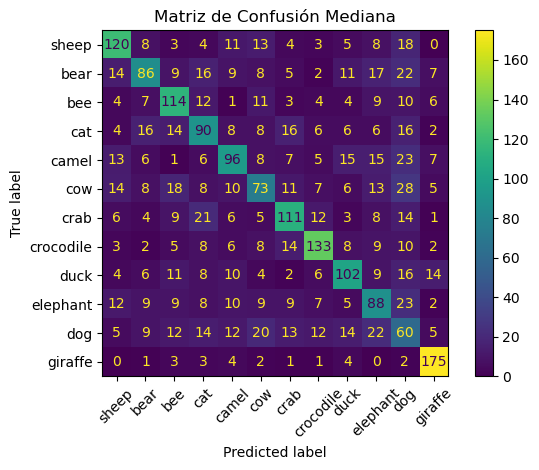

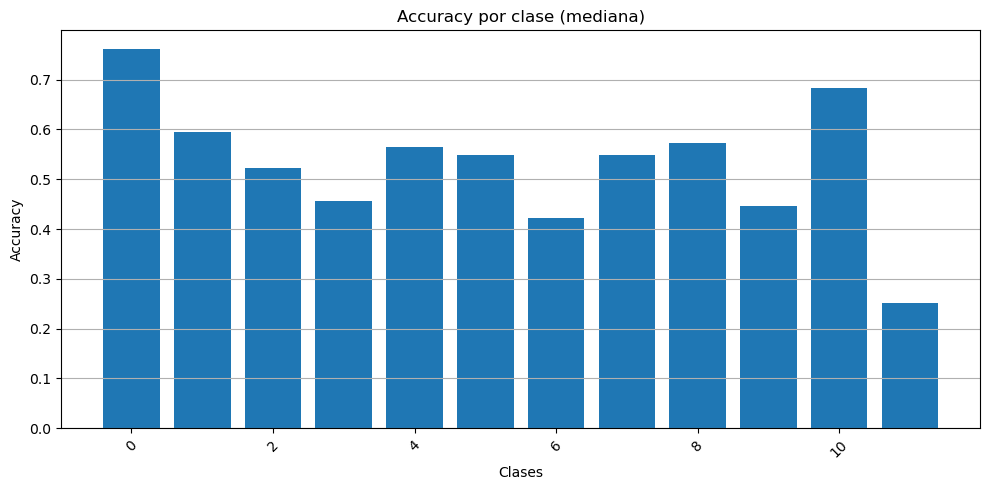

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals: 0.5198

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5085 - Loss: 3.5039
Accuracy por cada clase en Iteración 0 : [0.71755725 0.48148148 0.57920792 0.4279476  0.57232704 0.32132132
 0.53233831 0.70658683 0.57386364 0.46534653 0.2047619  0.75770925]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5177 - Loss: 3.2972
Accuracy por cada clase en Iteración 1 : [0.6374269  0.45833333 0.58128079 0.41826923 0.5755814  0.43023256
 0.45575221 0.69273743 0.56923077 0.41825095 0.22580645 0.79807692]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5244 - Loss: 3.3758
Accuracy por cada clase en Iteración 2 : [0.605      0.52830189 0.53365385 0.50641026 0.51442308 0.41025641
 0.48888889 0.68686869 0.49751244 0.43965517 0.28571429 0.8115942 ]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5169 - Loss: 3.3119
Accuracy por cada clase en Iteración 3 : [0.55744681 0.54037267 0.54123711 0.45933014 0.58823529 0.40104167
 0.53883495 0.60444444 0.48611111 0.43949045 0.26086957 0.73360656]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5248 - Loss: 3.4743
Accuracy por cada clase en Iteración 4 : [0.59798995 0.49238579 0.55721393 0.4972067  0.45045045 0.4137931
 0.48987854 0.65402844 0.58100559 0.46022727 0.25294118 0.79534884]
--------------------------------------------------------------------------------


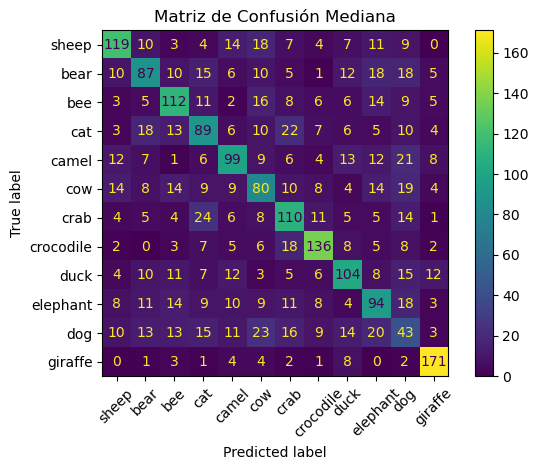

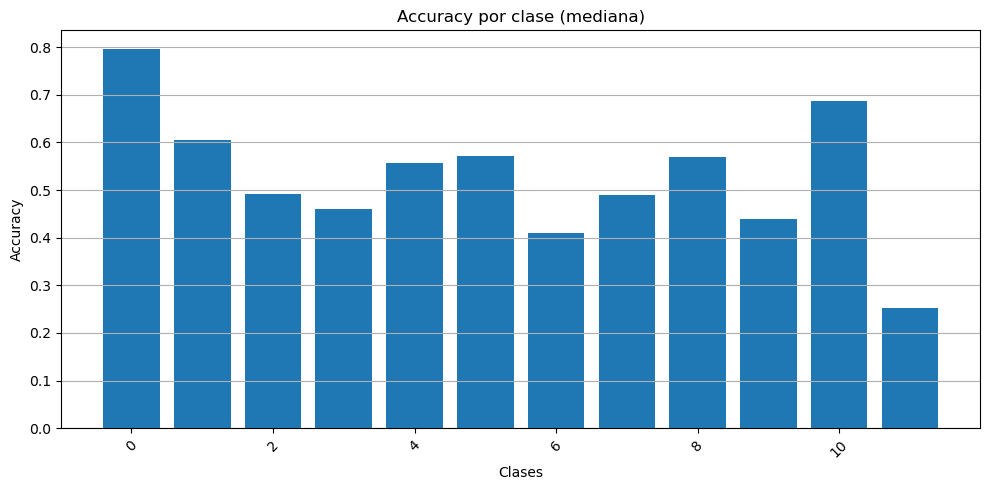

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals: 0.5177


In [23]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']} en QuickDraw-Animals...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_trainA_pca, y_trainA, X_testA_pca, y_testA,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_animals,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']} en QuickDraw-Animals: {mediana_acc:.4f}")
